In [59]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

from sklearn.model_selection import train_test_split
from functools import partial
from multiprocessing import Pool
from PIL import Image

In [60]:
def resize_with_aspect_ratio(image, target_size=(512, 512)):
    """
    Resizes an image to fit within a target size while maintaining the aspect ratio.
    Adds padding to center the image on a black background.

    Parameters:
        image (numpy.ndarray): Input image to resize.
        target_size (tuple): Target dimensions (height, width).

    Returns:
        numpy.ndarray: Padded image with the target dimensions.
    """
    # Original and target dimensions
    h, w = image.shape[:2]
    target_h, target_w = target_size
    
    # Calculate scale factor and new dimensions
    scale = min(target_w / w, target_h / h)
    new_dims = (int(w * scale), int(h * scale))
    
    # Resize image and create padded canvas
    resized_image = cv2.resize(image, new_dims, interpolation=cv2.INTER_AREA)
    padded_image = np.full((target_h, target_w, 3), 0, dtype=np.uint8)
    
    # Calculate offsets for centering
    y_offset = (target_h - new_dims[1]) // 2
    x_offset = (target_w - new_dims[0]) // 2
    
    # Place resized image on the canvas
    padded_image[y_offset:y_offset + new_dims[1], x_offset:x_offset + new_dims[0]] = resized_image
    return padded_image

In [61]:
def crop_retina_image(image_bgr, output_size=(512, 512)):
    """
    Crops a retina image to the largest contour's bounding rectangle and resizes it.

    Parameters:
        image_bgr (numpy.ndarray): Input image in BGR format.
        output_size (tuple): Target dimensions (height, width).

    Returns:
        numpy.ndarray: Cropped and resized image in BGR format.
    """
    # Validate the input image
    if image_bgr is None or image_bgr.size == 0:
        raise ValueError("Invalid or empty input image.")

    # Convert to grayscale and threshold to create a binary mask
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

    # Detect contours and validate their presence
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        raise ValueError("No contours found in the input image.")

    # Crop the largest contour's bounding rectangle
    x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    cropped = image_bgr[y:y+h, x:x+w]

    # Resize cropped image and return
    return resize_with_aspect_ratio(cropped, target_size=output_size)

In [62]:
def detect_exposure(image_bgr, over_threshold=200, under_threshold=15, exposure_ratio=0.6):
    """
    Detects whether an image is overexposed or underexposed based on pixel intensity thresholds.

    Parameters:
        image_bgr (numpy.ndarray): Input image in BGR format.
        over_threshold (int): Pixel intensity above this value is considered overexposed (default: 200).
        under_threshold (int): Pixel intensity below this value is considered underexposed (default: 20).
        exposure_ratio (float): Maximum allowed ratio of over/underexposed pixels (default: 0.7).

    Returns:
        tuple: 
            - is_not_overexposed (bool): Whether the image is not overexposed.
            - is_not_underexposed (bool): Whether the image is not underexposed.
            - over_ratio (float): Ratio of overexposed pixels.
            - under_ratio (float): Ratio of underexposed pixels.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # Calculate total pixels and counts of overexposed/underexposed pixels
    total_pixels = gray.size
    overexposed_pixels = np.sum(gray >= over_threshold)
    underexposed_pixels = np.sum(gray <= under_threshold)

    # Compute the ratios of overexposed and underexposed pixels
    over_ratio = overexposed_pixels / total_pixels
    under_ratio = underexposed_pixels / total_pixels

    # Check if the image is within acceptable exposure limits
    is_not_overexposed = over_ratio <= exposure_ratio
    is_not_underexposed = under_ratio <= exposure_ratio

    # Return the results
    return is_not_overexposed, is_not_underexposed, over_ratio, under_ratio

In [63]:
def create_output_folders(base_folder):
    """
    Creates necessary output folders for image categorization.

    Parameters:
        base_folder (str): Path to the base output folder.

    Returns:
        dict: Dictionary with keys ('Underexposed', 'Overexposed', 'Well-exposed') and paths to the corresponding folders.
    """
    # Ensure the base folder exists
    os.makedirs(base_folder, exist_ok=True)

    # Define and create subfolders
    folders = {"Underexposed": os.path.join(base_folder, "Underexposed"),
               "Overexposed": os.path.join(base_folder, "Overexposed"),
               "Well-exposed": os.path.join(base_folder, "Well-exposed")}
    for path in folders.values():
        os.makedirs(path, exist_ok=True)

    # Return the dictionary of folder paths
    return folders

In [64]:
def categorize_and_save_image(image_bgr, image_name, exposure_results, output_folders):
    """
    Categorizes an image based on exposure results and saves it in the appropriate folder.

    Parameters:
        image_bgr (numpy.ndarray): Image in BGR format to be saved.
        image_name (str): Name for the saved image file (without extension).
        exposure_results (tuple): Exposure results as (is_not_overexposed, is_not_underexposed, over_ratio, under_ratio).
        output_folders (dict): Dictionary of output folder paths with keys ('Underexposed', 'Overexposed', 'Well-exposed').

    Returns:
        tuple: 
            - category (str): Exposure category ('Well-exposed', 'Overexposed', 'Underexposed', or 'Error').
            - output_path (str or None): Path where the image was saved, or None if an error occurred.
            - over_ratio (float): Ratio of overexposed pixels.
            - under_ratio (float): Ratio of underexposed pixels.
    """
    # Unpack exposure results
    is_not_overexposed, is_not_underexposed, over_ratio, under_ratio = exposure_results

    # Determine the category based on exposure results
    if is_not_overexposed and is_not_underexposed:
        category = "Well-exposed"
    elif not is_not_overexposed:
        category = "Overexposed"
    elif not is_not_underexposed:
        category = "Underexposed"
    else:
        return "Error", None, over_ratio, under_ratio

    # Construct the output path for the image
    output_path = os.path.join(output_folders[category], f"{image_name}.jpeg")

    # Save the image in BGR format directly
    cv2.imwrite(output_path, image_bgr)
    
    # Return the category, path, and exposure ratios
    return category, output_path, over_ratio, under_ratio

In [65]:
def process_images_with_histogram_statistics(image_folder, csv_path, output_folder, output_size=(512, 512), max_workers=12):
    """
    A parallelized pipeline for processing images:
    1. Reads a CSV file with image metadata and sets up output folders.
    2. Processes images in parallel using a ThreadPoolExecutor.
    3. Aggregates histograms and builds a DataFrame with results.

    Parameters:
        image_folder (str): Path to the folder containing input images.
        csv_path (str): Path to the CSV file containing image metadata.
        output_folder (str): Path to the folder where categorized images will be saved.
        output_size (tuple): Desired output size (width, height) for cropped images. Default is (512, 512).
        max_workers (int): Maximum number of worker threads for parallel processing. Default is 8.

    Returns:
        tuple: A tuple containing:
            - results_df (pd.DataFrame): DataFrame with processing results for all images.
            - aggregated_hist (np.ndarray or None): Mean histogram of all processed images (if any).
            - std_hist (np.ndarray or None): Standard deviation of histograms across all images (if any).
    """
    # Step 1: Create categorized output folders
    output_folders = create_output_folders(output_folder)

    # Step 2: Read the CSV file into a DataFrame
    labels_df = pd.read_csv(csv_path)

    # Initialize containers for results and histograms
    all_results = []  # Stores processing results for all images
    all_hists = []    # Stores histograms for aggregation

    # Step 3: Process images in parallel using ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        # Submit a job to the executor for each row in the CSV
        for _, row in labels_df.iterrows():
            future = executor.submit(process_single_row, row, image_folder, output_folders, output_size)
            futures.append(future)

        # Process results as futures complete
        for f in tqdm(as_completed(futures), total=len(futures), desc="Processing in parallel"):
            res = f.result()  # Retrieve the result of the completed task
            all_results.append(res)

            # If the result contains a valid histogram, store it for aggregation
            if "histogram" in res and res["histogram"] is not None:
                all_hists.append(res["histogram"])

    # Step 4: Build a DataFrame from the results
    results_df = pd.DataFrame(all_results)

    # Step 5: Aggregate histograms across all processed images
    if len(all_hists) > 0:
        all_hists = np.array(all_hists, dtype=float)  # Convert to a NumPy array for easier computation
        aggregated_hist = np.mean(all_hists, axis=0)  # Compute the mean histogram
        std_hist = np.std(all_hists, axis=0)          # Compute the standard deviation histogram
    else:
        aggregated_hist = None  # No histograms to aggregate
        std_hist = None         

    # Return the final results DataFrame and histogram statistics
    return results_df, aggregated_hist, std_hist

In [66]:
def process_single_image(row, results, per_image_histograms, output_size):
    """
    Processes a single image: cropping, resizing, and histogram computation.

    Parameters:
        row (pd.Series): Row of the DataFrame containing image metadata.
        results (list): List to store processing results.
        per_image_histograms (list): List to store individual image histograms.
        output_size (tuple): Target size for image resizing.

    Returns:
        None
    """
    image_name, label, image_path = row["image"], row["level"], row["image_path"]

    if not os.path.isfile(image_path):
        results.append({"image": image_name, "label": label, "category": "File not found"})
        return

    try:
        # Load and process the image
        bgr_image = cv2.imread(image_path)
        cropped_bgr = crop_retina_image(bgr_image, output_size)

        if cropped_bgr is None or cropped_bgr.size == 0:
            raise ValueError(f"Invalid cropped image for {image_name}")

        # Convert to grayscale and compute histogram
        gray_image = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)
        hist, _ = np.histogram(gray_image.ravel(), bins=256, range=(0, 256), density=False)

        per_image_histograms.append(hist)

        # Store intermediate results
        results.append({"image": image_name,
                        "label": label,
                        "cropped_image": cropped_bgr,
                        "gray_image": gray_image})

    except Exception as e:
        print(f"Error processing {image_name}: {e}")
        results.append({"image": image_name, "label": label, "category": "Error"})

In [67]:
def categorize_images(results, output_folders):
    """
    Categorizes images based on exposure and saves them in respective folders.

    Parameters:
        results (list): List of results with cropped images.
        output_folders (dict): Dictionary of output folder paths.

    Returns:
        list: Final results with categorization and exposure ratios.
    """
    final_results = []

    for result in tqdm(results, desc="Categorizing Images"):
        if "cropped_image" not in result:
            final_results.append(result)
            continue

        cropped_bgr = result.pop("cropped_image")

        # Detect exposure and categorize
        exposure_results = detect_exposure(cropped_bgr)
        category, _, over_ratio, under_ratio = categorize_and_save_image(
            cropped_bgr,
            result["image"],
            exposure_results,
            output_folders)

        # Update result with categorization details
        result.update({"category": category,
                       "over_ratio": over_ratio,
                       "under_ratio": under_ratio})
        final_results.append(result)

    return final_results

In [68]:
def generate_summary_table(results_df):
    """
    Generates a summary table of counts based on category and label.

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing at least 'category' and 'label' columns.

    Returns:
        pandas.DataFrame: Summary table with categories as rows, labels as columns, and counts as values.
    """
    # Group by 'category' and 'label', count occurrences, and reshape into a table
    return results_df.groupby(["category", "label"]).size().unstack(fill_value=0)

In [69]:
def plot_image_exposure_distributions(results_df, threshold=0.6):
    """
    Plots histograms for the distribution of underexposure and overexposure ratios.

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing 'under_ratio' and 'over_ratio' columns.
        threshold (float): Threshold for distinguishing well-exposed images (default: 0.7).

    Returns:
        None
    """

    def plot_exposure(ax, data, color, title, label):
        """
        Internal helper to plot a single exposure distribution histogram.

        Parameters:
            ax (matplotlib.axes.Axes): Axis to plot on.
            data (pandas.Series): Exposure ratio data (e.g., 'under_ratio' or 'over_ratio').
            color (str): Color for the histogram and regions.
            title (str): Title for the subplot.
            label (str): Label for the histogram values.
        """
        # Plot histogram
        ax.hist(data, bins=128, alpha=0.7, color=color, label=f"{label} Values", log=True)
        
        # Plot threshold line
        ax.axvline(x=threshold, color="green", linestyle="--", label="Well-Exposed Threshold")
        
        # Add shaded regions
        ax.fill_betweenx([1, ax.get_ylim()[1]], 0, threshold, color="green", alpha=0.2, label="Well-Exposed Region")
        ax.fill_betweenx([1, ax.get_ylim()[1]], threshold, 1, color=color, alpha=0.2, label=f"{label} Region")
    
        # Add titles and labels
        ax.set_title(title, fontsize=16)
        ax.set_xlabel(f"{label} Ratio", fontsize=14)
        ax.set_ylabel("Number of Images (Log Scale)", fontsize=14)

        # Add grid and set limits
        ax.grid(alpha=0.5)
        ax.set_xlim(left=0)
        # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y)}"))
        ax.legend(fontsize=12)
        

    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    # Plot underexposure and overexposure histograms
    plot_exposure(axes[0], results_df["under_ratio"], "blue", "Underexposure Distribution", "Underexposure")
    plot_exposure(axes[1], results_df["over_ratio"], "red", "Overexposure Distribution", "Overexposure")

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

In [70]:
def plot_histogram_statistics(aggregated_histogram, std_histogram):
    """
    Plots the aggregated pixel intensity histogram with statistical markers (mean, median, mode),
    the standard deviation range, and includes an additional plot in symmetric log scale with symmetric limits.

    Parameters:
        aggregated_histogram (np.ndarray): The aggregated histogram of pixel intensities (length 256).
        std_histogram (np.ndarray): The standard deviation of the histogram values (length 256).
    
    Returns:
        None
    """
    def plot_histogram(intensities, histogram, std, mean_val, median_val, mode_val, log_scale=False, symmetric_limit=None):
        """
        Internal function to handle plotting logic.

        Parameters:
            intensities (np.ndarray): Pixel intensity values (0-255).
            histogram (np.ndarray): Histogram values for the intensities.
            std (np.ndarray): Standard deviation for the histogram values.
            mean_val (float): Mean pixel intensity value.
            median_val (float): Median pixel intensity value.
            mode_val (float): Mode pixel intensity value.
            log_scale (bool): Whether to use a log or symmetric log scale for the y-axis.
            symmetric_limit (float): Maximum value for symmetric y-axis limits (used in symlog scale).

        Returns:
            None
        """
        plt.figure(figsize=(12, 6))
        plt.bar(intensities, histogram, color="gray", alpha=0.7, label="Mean Histogram")
        plt.fill_between(intensities,
                         histogram - std,  # Lower bound
                         histogram + std,  # Upper bound
                         color="blue", alpha=0.3, label="Std Dev Range")

        # Add vertical lines for statistics
        plt.axvline(mean_val, color="red", linestyle="--", linewidth=1.5, label=f"Mean: {mean_val:.2f}")
        plt.axvline(median_val, color="green", linestyle="--", linewidth=1.5, label=f"Median: {median_val:.2f}")
        plt.axvline(mode_val, color="orange", linestyle="--", linewidth=1.5, label=f"Mode: {mode_val:.0f}")

        plt.title("Aggregated Pixel Intensity Histogram" + (" (Log Scale)" if log_scale else ""), fontsize=16)
        plt.xlabel("Pixel Intensity", fontsize=14)
        plt.ylabel("Log(Frequency)" if log_scale else "Frequency", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(alpha=0.4)

        # Set y-axis to log scale if required
        if log_scale:
            plt.yscale("symlog", linthresh=1)  # Symmetric log scale with a linear threshold at ±1
            plt.ylim(-symmetric_limit, symmetric_limit)  # Ensure symmetric y-axis limits

        plt.show()

    # Define the range of pixel intensities (0 to 255)
    intensities = np.arange(256)

    # Calculate statistical values
    mean_val = np.sum(aggregated_histogram * intensities) / np.sum(aggregated_histogram)
    cdf = np.cumsum(aggregated_histogram) / np.sum(aggregated_histogram)
    median_val = np.interp(0.5, cdf, intensities)
    mode_val = intensities[np.argmax(aggregated_histogram)]

    # Plot the regular histogram
    plot_histogram(intensities, aggregated_histogram, std_histogram, mean_val, median_val, mode_val, log_scale=False)

    # Calculate the maximum magnitude of the histogram for symmetric log-scale limits
    max_val = np.max(np.abs(aggregated_histogram + std_histogram))
    symmetric_limit = 10 ** np.ceil(np.log10(max_val))  # Round up to the nearest power of 10

    # Plot the log-scale histogram with symmetric limits
    plot_histogram(intensities, aggregated_histogram, std_histogram, mean_val, median_val, mode_val, log_scale=True, symmetric_limit=symmetric_limit)

In [71]:
def display_exposure_subplots(results_df, output_folder, num_images=5):
    """
    Displays a grid of images categorized by exposure levels (Underexposed, Overexposed, Well-exposed).

    Parameters:
        results_df (pandas.DataFrame): DataFrame containing image data with a 'category' and 'image' column.
        image_folder (str): Path to the folder containing categorized images.
        num_images (int): Number of images to display per category (default: 5).

    Returns:
        None
    """
    categories = ["Underexposed", "Overexposed", "Well-exposed"]
    fig, axes = plt.subplots(len(categories), num_images, figsize=(15, 9))
    fig.suptitle("Exposure Categories", fontsize=16)

    for i, category in enumerate(categories):
        # Get up to 'num_images' image names for the current category
        category_images = results_df[results_df["category"] == category]["image"].head(num_images)

        for j in range(num_images):
            ax = axes[i, j] if len(categories) > 1 else axes[j] 
            if j >= len(category_images):  # If there are no more images to display
                ax.axis("off")
                continue

            image_name = category_images.iloc[j]
            image_path = os.path.join(output_folder, category, f"{image_name}.jpeg")

            if os.path.isfile(image_path):
                # Load and display the image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    ax.imshow(image)
                    ax.axis("off")
                    ax.set_title(image_name, fontsize=10)  # Add image name above the image
                else:
                    ax.axis("off")
            else:
                ax.axis("off")

        # Add row labels using a simple ylabel
        axes[i, 0].set_ylabel(category, fontsize=12, fontweight='bold', rotation=0, ha='right', va='center')

    # Adjust layout to make room for labels
    plt.subplots_adjust(left=0.15)
    plt.tight_layout(rect=[0.15, 0, 1, 0.95])
    plt.show()

In [72]:
def process_single_row(row, image_folder, output_folders, output_size):
    """
    Processes a single row of image data:
    - Loads an image
    - Crops it to the retina area
    - Converts it to grayscale
    - Computes its histogram
    - Detects exposure levels
    - Categorizes and saves the image in the appropriate folder
    - Returns a dictionary with processing results, including the histogram for aggregation.

    Parameters:
        row (dict): A dictionary containing metadata about the image (e.g., image name, level).
        image_folder (str): Path to the folder containing the input images.
        output_folders (dict): Dictionary mapping exposure categories to output folder paths.
        output_size (tuple): Desired output size (width, height) for cropped images.

    Returns:
        dict: A dictionary containing the processed image's details, including:
            - image: Image name
            - label: Original label from the input data
            - category: Exposure category (e.g., underexposed, overexposed)
            - over_ratio: Percentage of overexposed pixels
            - under_ratio: Percentage of underexposed pixels
            - histogram: Grayscale intensity histogram
    """
    # Extract the image name and label from the input row
    image_name = row["image"]
    label = row["level"]
    # Construct the full path to the image file
    image_path = os.path.join(image_folder, f"{image_name}.jpeg")

    # Initialize the result dictionary with default values
    result = {"image": image_name,
              "label": label,
              "category": None,
              "over_ratio": None,
              "under_ratio": None}

    # Check if the image file exists; if not, categorize as "File not found"
    if not os.path.isfile(image_path):
        result["category"] = "File not found"
        return result

    try:
        # Load the image using OpenCV
        bgr_image = cv2.imread(image_path)

        # Crop the image to focus on the retina area
        cropped_bgr = crop_retina_image(bgr_image, output_size)

        # Convert the cropped image to grayscale for histogram computation
        gray_image = cv2.cvtColor(cropped_bgr, cv2.COLOR_BGR2GRAY)

        # Compute the grayscale intensity histogram (256 bins, range 0-255)
        hist, _ = np.histogram(gray_image.ravel(), bins=256, range=(0, 256), density=False)

        # Detect exposure levels (e.g., underexposed, overexposed) in the cropped image
        exposure_results = detect_exposure(cropped_bgr)

        # Categorize the image based on exposure levels and save it to the appropriate folder
        category, _, over_ratio, under_ratio = categorize_and_save_image(
            cropped_bgr, image_name, exposure_results, output_folders)

        # Update the result dictionary with exposure details and histogram
        result["category"] = category
        result["over_ratio"] = over_ratio
        result["under_ratio"] = under_ratio
        result["histogram"] = hist  # Add the histogram for later aggregation

    except Exception as e:
        # Handle any errors during processing
        print(f"Error processing {image_name}: {e}")
        result["category"] = "Error"

    # Return the processed results
    return result

Processing in parallel: 100%|██████████| 35126/35126 [00:00<00:00, 173670.00it/s]



Exposure Summary:
label               0     1     2    3    4
category                                   
File not found  25798  2439  5290  872  706
Overexposed         3     1     0    1    0
Underexposed        4     1     1    0    0
Well-exposed        5     2     1    0    2


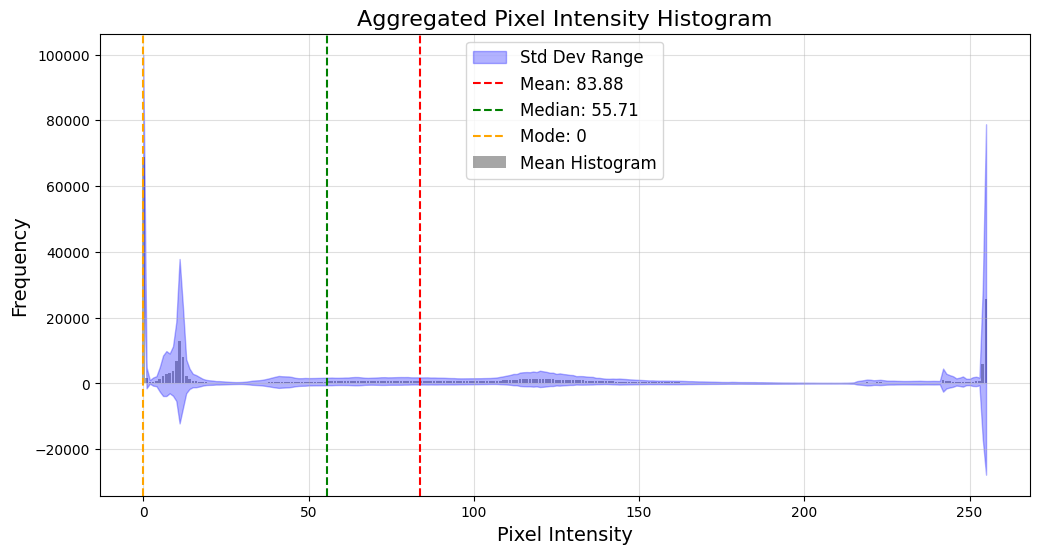

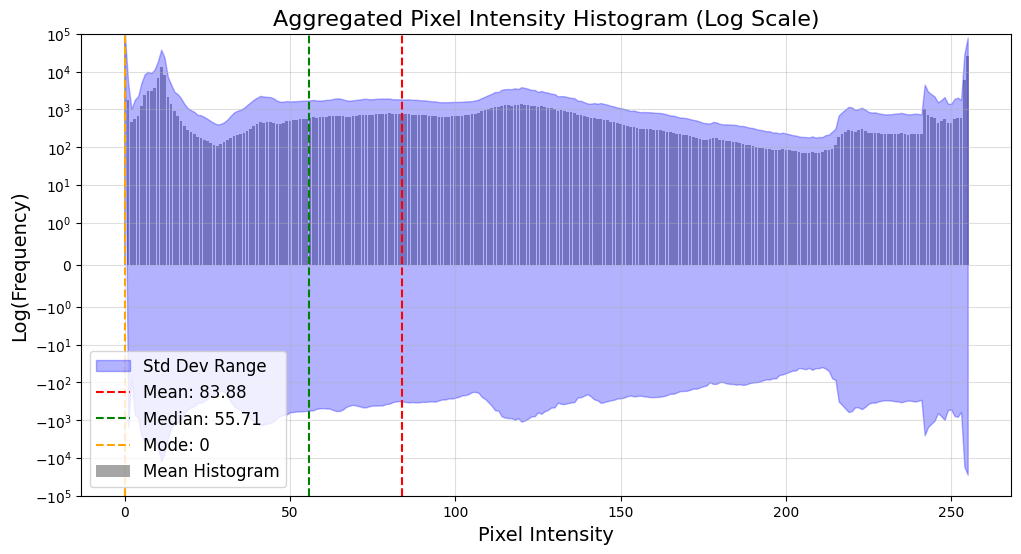

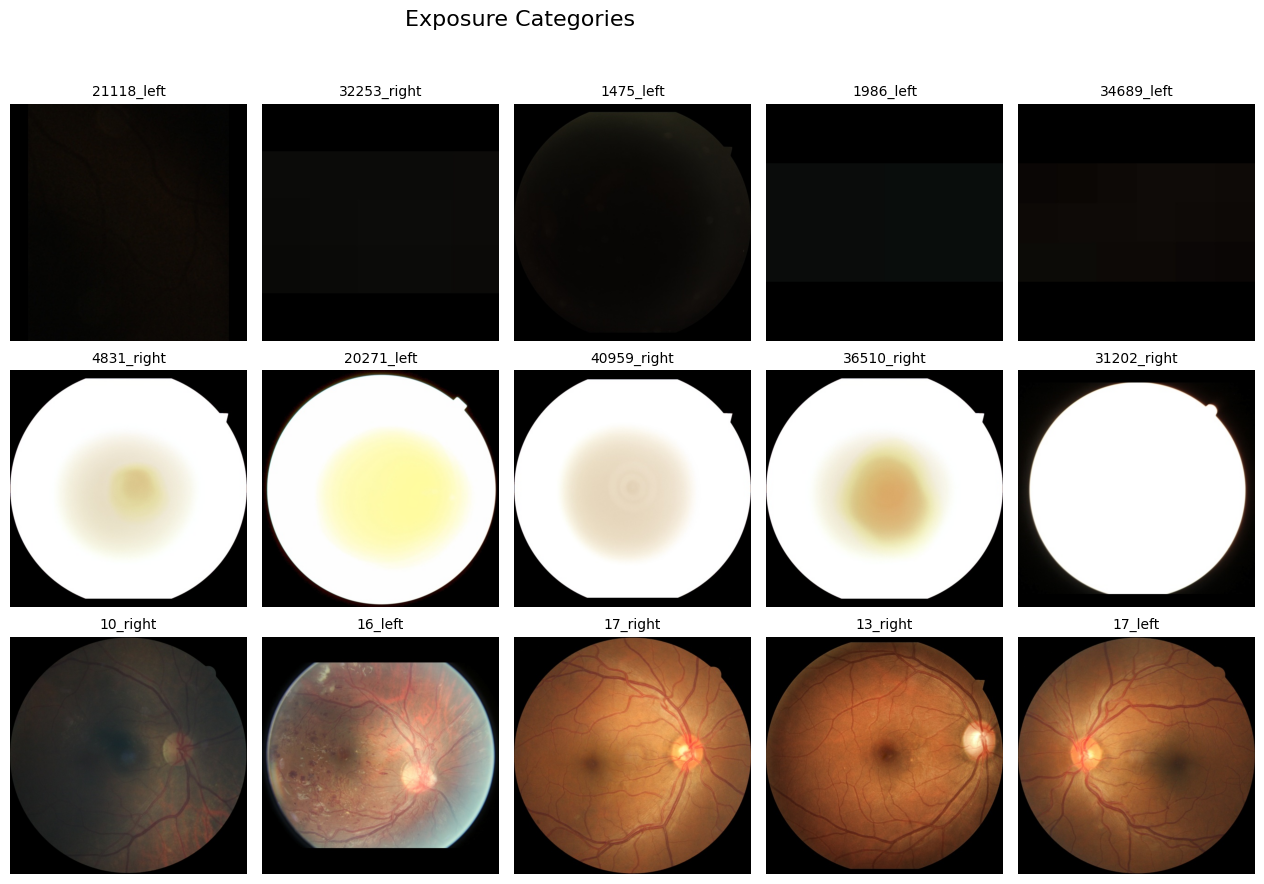

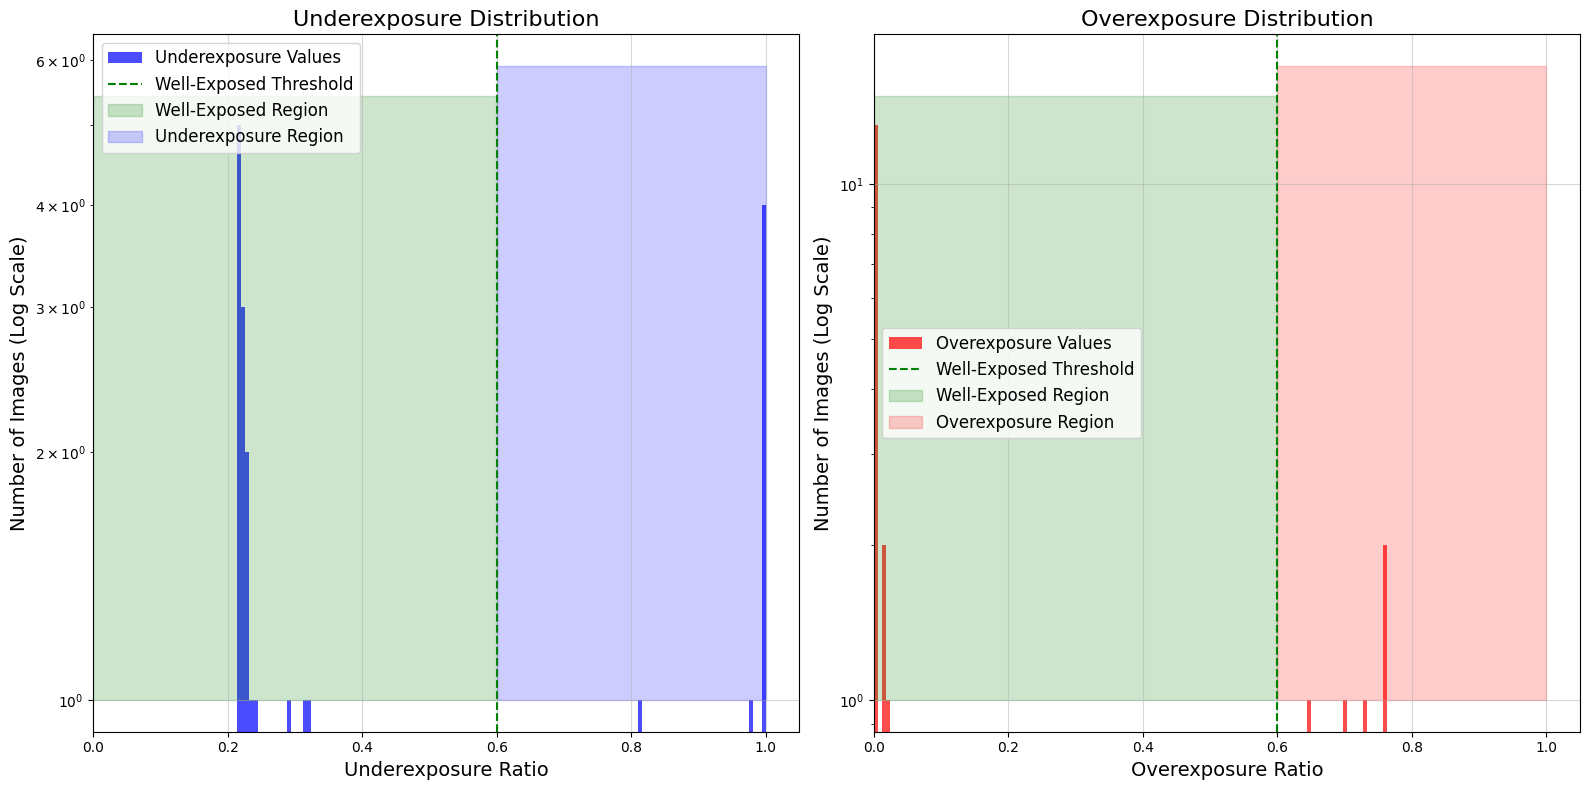

In [73]:
if __name__ == '__main__':
    # plt.style.use('default')
    image_folder = 'Data/train'
    output_folder = 'Data/Cropped_W_Exposure'
    csv_path = 'Data/trainLabels.csv'

    # PARALLEL EXECUTION
    results_df, aggregated_histogram, std_histogram = process_images_with_histogram_statistics(image_folder, csv_path, output_folder)

    # Save and display results
    results_df.to_csv("Data/exposure_results_with_labels.csv", index=False)

    summary_table = generate_summary_table(results_df)
    print("\nExposure Summary:")
    print(summary_table)
    summary_table.to_csv("Data/exposure_summary_table.csv")

    # Plot histogram statistics
    if aggregated_histogram is not None and std_histogram is not None:
        plot_histogram_statistics(aggregated_histogram, std_histogram)

    # Display example subplots
    display_exposure_subplots(results_df, output_folder)

    # Plot distributions
    plot_image_exposure_distributions(results_df)

In [74]:
# # Load CSV and associate image paths
# def load_data(csv_path, image_folder):
#     df = pd.read_csv(csv_path)
#     df["image_path"] = df["image"].apply(lambda x: os.path.join(image_folder, f"{x}.jpeg"))
#     return df

In [75]:
# # Split data into Train, Validation, and Test sets
# def split_data(df, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2, random_state=42):
#     assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."
#     
#     # First split into Train and Temp (Val + Test)
#     train_df, temp_df = train_test_split(df, 
#         test_size=(1 - train_ratio), 
#         stratify=df["level"], 
#         random_state=random_state)
#     
#     # Then split Temp into Validation and Test
#     val_df, test_df = train_test_split(temp_df, 
#         test_size=(test_ratio / (val_ratio + test_ratio)), 
#         stratify=temp_df["level"], 
#         random_state=random_state)
#     
#     return train_df, val_df, test_df

In [76]:
# # Load images into memory
# def load_images(df):
#     images = []
#     labels = []
#     for _, row in df.iterrows():
#         image_path = row["image_path"]
#         label = row["level"]
#         try:
#             # Load image and convert to RGB
#             image = Image.open(image_path).convert("RGB")
#             images.append(image)
#             labels.append(label)
#         except Exception as e:
#             print(f"Error loading image {image_path}: {e}")
#     return images, labels

In [77]:
# # Main script
# if __name__ == "__main__":
#     csv_path = "trainLabels.csv"
#     image_folder = "Cropped_W_Exposure"
#     
#     # Load dataset
#     df = load_data(csv_path, image_folder)
#     
#     # Split dataset
#     train_df, val_df, test_df = split_data(df)
#     
#     print(f"Train: {len(train_df)}, Validation: {len(val_df)}, Test: {len(test_df)}")
#     
#     # Load images into memory
#     train_images, train_labels = load_images(train_df)
#     val_images, val_labels = load_images(val_df)
#     test_images, test_labels = load_images(test_df)
#     
#     print(f"Loaded {len(train_images)} train images, {len(val_images)} validation images, {len(test_images)} test images.")